# PRAC2: Limpieza y análisis de datos - Black Friday

## 1. Descripción del dataset

In [1]:
# En primer lugar, importamos las librerías necesarias
import sys
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pylab 
#import scipy.stats as stats

In [2]:
# Cargamos los datos del dataset en un dataframe
black_data = pd.read_csv("BlackFriday.csv")
black_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
# Veamos los descriptores estadísticos de las variables paramétricas
black_data.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [4]:
# Verificamos los tipos de valor en cada celda
black_data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [5]:
# Corregimos aquellos que aparecen como numéricos pero son categóricos. 
cat_values = ["Gender", "Age", "Occupation", "City_Category", "Marital_Status", "Product_Category_1", 
              "Product_Category_2", "Product_Category_3"]
for column in cat_values:
    black_data[column] = black_data[column].astype('category')
black_data.dtypes

User_ID                          int64
Product_ID                      object
Gender                        category
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years      object
Marital_Status                category
Product_Category_1            category
Product_Category_2            category
Product_Category_3            category
Purchase                         int64
dtype: object

## 3. Limpieza de los datos

### 3.1 Datos perdidos

In [6]:
# Utilizamos la función isnull para ver cuántos registros tienen valor vacío, NA o NaN
black_data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

In [7]:
# Verificamos si hay valores pérdidos con otras sintaxis
# Definimos los valores NA comunes en una lista
missing_values = ["n/a", "na", "--", "Na"]
black_data = pd.read_csv("BlackFriday.csv", na_values= missing_values)
black_data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64


Solo las columnas Product_Category_2 y Product_Category_3 tienen datos perdidos. Verifiquemos la correlación entre variables para verificar si las variables con valores pérdidos tienen alguna correlación alta con las demás:

In [8]:
black_data.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023024,0.018732,0.003687,0.001471,0.004045,0.005389
Occupation,-0.023024,1.000000,0.024691,-0.008114,-0.000031,0.013452,0.021104
Marital_Status,0.018732,0.024691,1.000000,0.020546,0.015116,0.019452,0.000129
Product_Category_1,0.003687,-0.008114,0.020546,1.000000,0.540423,0.229490,-0.314125
Product_Category_2,0.001471,-0.000031,0.015116,0.540423,1.000000,0.543544,-0.209973
Product_Category_3,0.004045,0.013452,0.019452,0.229490,0.543544,1.000000,-0.022257
Purchase,0.005389,0.021104,0.000129,-0.314125,-0.209973,-0.022257,1.000000


La correlación más fuerte la tienen entre ellas, por lo que una sustitución de los valores vacíos por 0 no tendría consecuencias para el modelo.

In [9]:
# Veamos si los valores vacíos en Product_Category_2 también lo están en Product_Category_3
len(black_data[black_data['Product_Category_2'].isnull() & black_data['Product_Category_3'].isnull()])

166986

<BarContainer object of 18 artists>

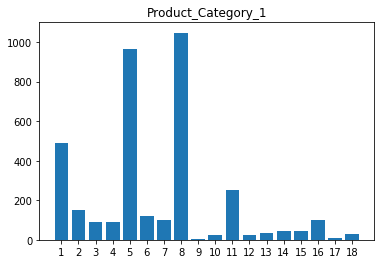

In [10]:
# Verificamos la distribución de Product_Category_1 para comparar con los valores pérdidos de Product_Category_2 y
#Product_Category_3
prod_1 = black_data['Product_ID'].groupby(black_data['Product_Category_1']).nunique()
prod_2 = black_data['Product_ID'].groupby(black_data['Product_Category_2']).nunique()
prod_3 = black_data['Product_ID'].groupby(black_data['Product_Category_3']).nunique()
prod_1

bins = np.sort(black_data['Product_Category_1'].unique())
plt.xticks(bins)
plt.title('Product_Category_1')
plt.bar(bins, prod_1)

In [11]:
print np.unique(prod_2)
print np.unique(prod_3)

[  4  12  14  18  20  45  51  60  70  76 127 128 138 146 221 317 353]
[  3   5   6  14  16  31  37  42  43  69  80 115]


Observamos que no hay categoría 0 en ninguna de ellas, por tanto, podríamos asignar a los valores pérdidos el valor 0 para identificar que no se conoce la categoría dentro del tipo de producto 2 y 3 al que pertenecen. 

De todas formas, al no tener un conocimiento funcional del significado de la categoría 2 y la categoría 3, nos parece más apropiado no tenerlas en cuenta en nuestro estudio. Utilizaremos únicamente la categoría 1 para clasificar el producto, cuyos datos no contienen vacíos y nos parecen más robustos. 

In [12]:
# Eliminamos las categorías 2 y 3 del data frame.
bf_data = black_data.drop(['Product_Category_2', 'Product_Category_3'], axis=1)

# Corregimos los tipos de datos. 
cat_values = ["Gender", "Age", "Occupation", "City_Category", "Marital_Status", "Product_Category_1"]

for column in cat_values:
    bf_data[column] = bf_data[column].astype('category')
bf_data.dtypes

User_ID                          int64
Product_ID                      object
Gender                        category
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years      object
Marital_Status                category
Product_Category_1            category
Purchase                         int64
dtype: object

### 3.2 Valores extremos

#### Valores extremos en la muestra completa

Text(0,0.5,'Purchase ($)')

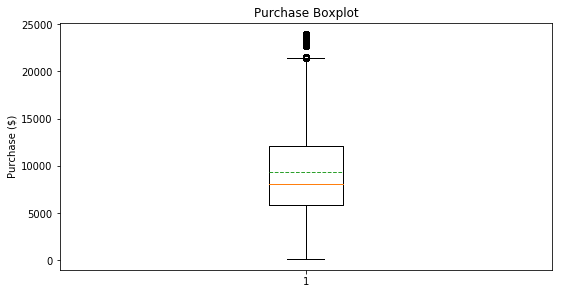

In [13]:
# Representamos el gráfico de cajas de la variable "Purchase" para la muestra completa
plt.figure(figsize=[30,10])
plt.subplot(231)
cajas = plt.boxplot(x=bf_data['Purchase'], showmeans = True, meanline = True)
plt.title('Purchase Boxplot')
plt.ylabel('Purchase ($)')

In [14]:
# Almacenamos los valores atípicos en una lista
outliers = list(cajas["fliers"][0].get_data()[1])

# Comparemos los tamaños de las muestras
print "Num. de datos atípicos", len(outliers)
print "Tamaño de la muestra completa", len(bf_data)

# Comprobamos la longitud para ver cuántos registros se consideran extremos.
print "Intervalo de valores atípicos:(", min(outliers),",", max(outliers), ")"

Num. de datos atípicos 2665
Tamaño de la muestra completa 537577
Intervalo de valores atípicos:( 21384 , 23961 )


In [15]:
# Veamos qué pasaría si eliminásemos los datos atípicos
bf_data_sin = bf_data[~bf_data.Purchase.isin(outliers)]
bf_data_sin.describe()

,User_ID,Purchase
count,5.349120e+05,534912.000000
mean,1.002991e+06,9264.683312
std,1.714130e+03,4895.538823
min,1.000001e+06,185.000000
25%,1.001495e+06,5857.000000
50%,1.003031e+06,8052.000000
75%,1.004416e+06,12037.000000
max,1.006040e+06,21382.000000


In [16]:
# Lo comparamos con la muestra completa.
bf_data.describe()

,User_ID,Purchase
count,5.375770e+05,537577.000000
mean,1.002992e+06,9333.859853
std,1.714393e+03,4981.022133
min,1.000001e+06,185.000000
25%,1.001495e+06,5866.000000
50%,1.003031e+06,8062.000000
75%,1.004417e+06,12073.000000
max,1.006040e+06,23961.000000


In [17]:
# Calculamos a partir de donde consideramos extremos (3 veces la diferencia inter cuartílica sobre el tercer cuartil):
Q3 = bf_data.quantile(q=.75)["Purchase"]
Q1 = bf_data.quantile(q=.25)["Purchase"]
a = Q3 + 3 * (Q3-Q1)
print "Son extremos valores > ", a
print "El máximo de la muestra es ",max(bf_data["Purchase"])

Son extremos valores >  30694.0
El máximo de la muestra es  23961


CORREGIR CON LOS NUEVOS DATOS??? Serían extremos los valores por encima de 30.694 pero el máximo de la muestra es 23.961, por lo que consideramos que ningún punto atípico es extremo analizando la muestra completa. 

#### Valores extremos por categoría

Vamos a analizar si existe algún valor extremo analizando los datos por cada uno de los campos del dataset.

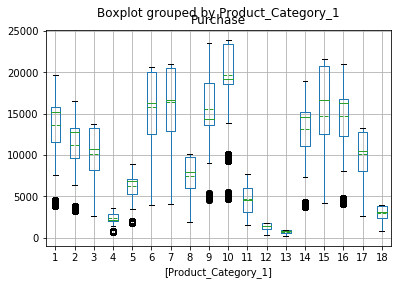

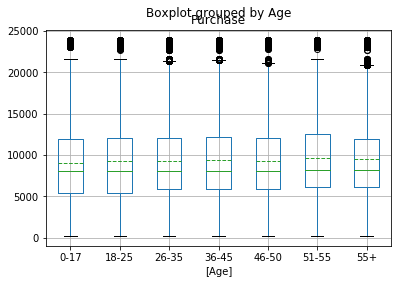

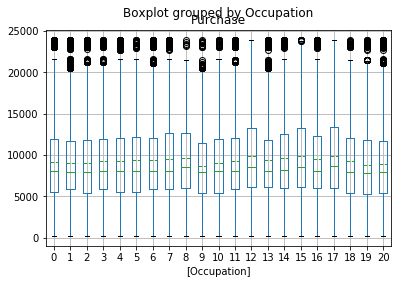

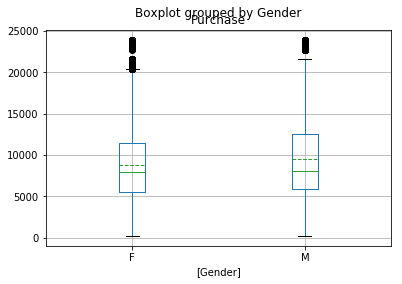

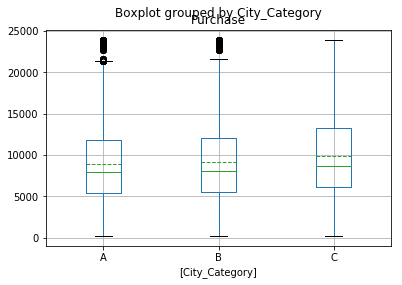

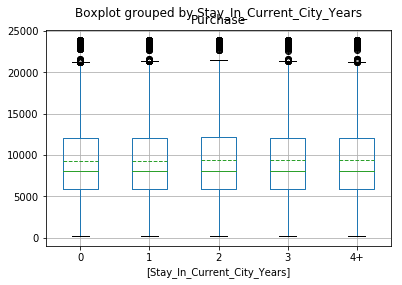

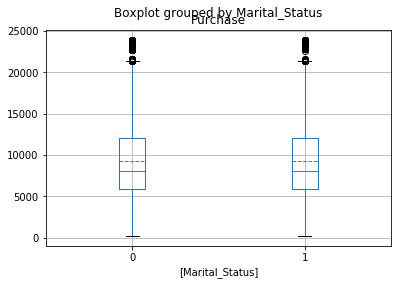

In [18]:
# Representamos el gráfico de cajas de la variable "Purchase" por los atributos.
caja_cat1 = bf_data.boxplot(column=['Purchase'], by=['Product_Category_1'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['Age'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['Occupation'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['Gender'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['City_Category'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['Stay_In_Current_City_Years'],showmeans = True, meanline = True)
bf_data.boxplot(column=['Purchase'], by=['Marital_Status'],showmeans = True, meanline = True)

,User_ID,Purchase
count,5.032000e+03,5032.000000
mean,1.003051e+06,19679.974364
std,1.731494e+03,4233.282571
min,1.000012e+06,4624.000000
25%,1.001519e+06,18545.000000
50%,1.003054e+06,19205.500000
75%,1.004543e+06,23438.000000
max,1.006040e+06,23961.000000


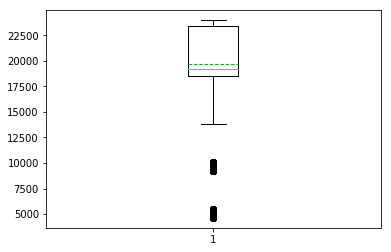

In [19]:
# Analicemos por separado los valores de Product_Category_1 = 10 ya que hemos visto en
# el boxplot que tiene valores atípicos bastante alejados del Q1

cat10 = bf_data[bf_data.Product_Category_1 == 10]
caja_cat10 = plt.boxplot(x=cat10['Purchase'],showmeans = True, meanline = True)
cat10.describe()

In [20]:
# Almacenamos los valores atípicos en una lista
out_cat10 = list(caja_cat10["fliers"][0].get_data()[1])
print "Categoría = 10: Num. de datos atípicos", len(out_cat10)
print("Intervalo de valores atípicos: ( %.2d , %.2d )" % (min(out_cat10) , max(out_cat10)))

# Calculamos a partir de donde consideramos extremos:
Q3 = cat10.quantile(q=.75)["Purchase"]
Q1 = cat10.quantile(q=.25)["Purchase"]
b = Q1 - 3 * (Q3-Q1)
print "Son extremos valores < ", b
print "El mínimo de la muestra es ",min(cat10["Purchase"])

Categoría = 10: Num. de datos atípicos 274
Intervalo de valores atípicos: ( 4624 , 10136 )
Son extremos valores <  3866.0
El mínimo de la muestra es  4624


No haremos ninguna acción con los datos atípicos ya que no los consideramos extremos y son coherentes con el resto de la muestra. Analizando las ventas según los valores que toman el resto de campos, tampoco vemos que haya ningún dato extremo o sospechoso de serlo.

## 4. Análisis de datos

### 4.2. Comprobación de la normalidad y homogeneidad de la varianza 

### Normalidad

Como la mayoría de las variables son categóricas, comprobaremos de normalidad sobre el subset de Purchase que corresponde a las variables categóricas que consideramos relevantes.  

(array([8.1160e+03, 2.4059e+04, 2.8913e+04, 2.8324e+04, 6.8395e+04,
        6.1714e+04, 6.9581e+04, 3.4863e+04, 3.9891e+04, 3.9288e+04,
        1.8933e+04, 6.0470e+03, 3.0066e+04, 3.3862e+04, 2.0980e+03,
        1.1339e+04, 2.3486e+04, 6.2860e+03, 1.0000e+01, 2.3060e+03]),
 array([  185. ,  1373.8,  2562.6,  3751.4,  4940.2,  6129. ,  7317.8,
         8506.6,  9695.4, 10884.2, 12073. , 13261.8, 14450.6, 15639.4,
        16828.2, 18017. , 19205.8, 20394.6, 21583.4, 22772.2, 23961. ]),
 <a list of 20 Patch objects>)

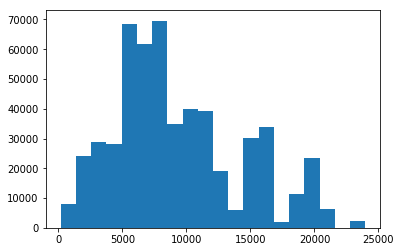

In [21]:
# Visualizamos la distribución de la variable Purchase sobre su histograma.
plt.hist(bf_data['Purchase'], bins=20)

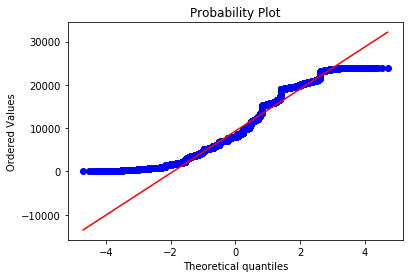

In [22]:
# Veamos como se acerca a una ditribución nomral.
stats.probplot(bf_data['Purchase'], dist="norm", plot=pylab)
plt.show()

En ambas gráficas podemos ver que no se acerca del todo a una distribución normal. 

Vamos a comprobarlo aplicando el test de Shapiro:

In [23]:
#Aplicamos el test una muestra porque el resultado de p-value no es preciso para muestras mayores a 5000
stats.shapiro(bf_data['Purchase'].sample(n=5000, random_state=1))

(0.9529308080673218, 2.2447729685418054e-37)

Podemos concluir que la variable Purchase no es normal porque el p-value <0.05. Por tanto, se rechaza la hipótesis nula.

Comprobemos la normalidad de la variable Purchase sobre las muestras de las variables Gender, Age, City_category y Marital_Status:

In [24]:
bf_data['Marital_Status'] = bf_data['Marital_Status'].astype('string')
data_select = ['Gender', 'Age', 'City_Category', 'Marital_Status']
for value in data_select:
    var = bf_data[value].unique()
    for i in range(len(var)):
        shap_num = stats.shapiro(bf_data['Purchase'][bf_data[value]==var[i]].sample(n=4000, random_state =1))
        shap_dict = {value +  var[i]: shap_num[1]}
        print shap_dict
        

{'GenderF': 4.860132656335689e-37}
{'GenderM': 1.622617137044561e-33}
{'Age0-17': 5.367863269783801e-34}
{'Age55+': 4.00766833593923e-35}
{'Age26-35': 1.563721162210207e-35}
{'Age46-50': 1.515031072693757e-34}
{'Age51-55': 9.342797876266847e-34}
{'Age36-45': 2.411296612794047e-34}
{'Age18-25': 1.1716942266898624e-35}
{'City_CategoryA': 1.5349875573779245e-35}
{'City_CategoryC': 3.27519863528204e-34}
{'City_CategoryB': 1.7345011772318997e-35}
{'Marital_Status0': 3.9950443990486123e-35}
{'Marital_Status1': 2.230614751083637e-35}


Observamos que la variable Purchase con respecto a las variables 'Gender', 'Age', 'City_Category' y 'Marital_Status' presenta una distribución no normal. 

### Homocedasticidad

In [25]:
# Al no seguir una distribución normal, comprobamos la homocedasticidad utilizando el test de Fligner-Killen
for value in data_select:
    var = bf_data[value].unique()
    for i in range(len(var)):
        flig_num = stats.fligner(bf_data['Purchase'], bf_data['Purchase'][bf_data[value]==var[i]])
        if flig_num[1] <0.05:
            flig_stat = u"presentan varianzas diferentes"
        elif flig_num[1] >= 0.05:
            flig_stat = u"presentan varianzas similares"
        flig_dict = {value +  var[i] + " & Purchase": flig_stat.encode('utf8')}
        print flig_dict
        

{'GenderF & Purchase': 'presentan varianzas diferentes'}
{'GenderM & Purchase': 'presentan varianzas diferentes'}
{'Age0-17 & Purchase': 'presentan varianzas diferentes'}
{'Age55+ & Purchase': 'presentan varianzas diferentes'}
{'Age26-35 & Purchase': 'presentan varianzas similares'}
{'Age46-50 & Purchase': 'presentan varianzas diferentes'}
{'Age51-55 & Purchase': 'presentan varianzas similares'}
{'Age36-45 & Purchase': 'presentan varianzas similares'}
{'Age18-25 & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryA & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryC & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryB & Purchase': 'presentan varianzas diferentes'}
{'Marital_Status0 & Purchase': 'presentan varianzas similares'}
{'Marital_Status1 & Purchase': 'presentan varianzas similares'}


Observamos que Purchase presenta varianzas similares con respecto a los siguientes grupos:
- Personas entre 26 y 45 años
- Personas entre 51 y 55 años
- Personas con estado civil representado por '0'

Al no presentar distribución normal  ni homocedasticidad en la mayoría de los casos, no podremos aplicar métodos de contraste de hipótesis de tipo paramétrico.

### Comparación

Vamos a comprobar la dependencia de los atributos relacionados con el cliente (edad, género, ocupación...) y la categoría de producto que consulme.

Al ser variables categóricas, utilizaremos el Test Chi cuadrado. 

In [26]:
# Separamos por un lado las variables relacionadas con el usuario.
user_att = ['Gender', 'Age', 'City_Category', 'Marital_Status', 'Occupation', 'City_Category' ]

# Por el otro lado, la categoría del producto
p_cat = ['Product_Category_1']

# Nuestra hipótesis nula será que son dependientes la categoría de producto y el atributo de cliente correspondiente.
for i in user_att:
    for j in p_cat:
        tabla_cont = pd.crosstab(bf_data[i], bf_data[j])
        chi2, p, dof, ex = stats.chi2_contingency(tabla_cont, correction=True, lambda_=None)
        # Suponiendo un nivel de significancia del 5%:
        if p <0.05:
            print  i, ' es dependiente de ', j,'p = ', p
        else:
            print 'p = ', p,i, ' puede que sea independiente de',j,', necesario estudiar más a fondo '

Gender  es dependiente de  Product_Category_1 p =  0.0
Age  es dependiente de  Product_Category_1 p =  0.0
City_Category  es dependiente de  Product_Category_1 p =  1.282214203551789e-215
Marital_Status  es dependiente de  Product_Category_1 p =  3.413899766728691e-101
Occupation  es dependiente de  Product_Category_1 p =  0.0
City_Category  es dependiente de  Product_Category_1 p =  1.282214203551789e-215


Los valores de p son 0 o próximos a 0 para todos los atributos, por lo que existe dependencia y, por lo tanto, se ven diferencias entre las compras realizadas por cada uno de los valores de cada atributos. 

### 4.3. Pruebas estadísticas

### Métodos supervisados

In [27]:
#creamos una nueva variable para predecir el tipo de cliente de acuerdo a lo que gasta
bf_data['Purch_class'] = np.where(bf_data['Purchase']>=14000, 'premium', 'standard')

#separamos las variables dependientes e independientes
X = bf_data.drop(['Purchase', 'Purch_class'], axis=1)
Y = bf_data['Purch_class']

#seleccionamos las variables categóricas a aplicar LabelEncoder para aplicar el algoritmo de clasificación
level_var = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'User_ID', 'Product_ID']
#transformamos las variables categóricas en números que corresponden a cada categoría
for feature in level_var:
    X.loc[:,feature] = LabelEncoder().fit_transform(X[feature])

Y = LabelEncoder().fit_transform(Y)

#obtenemos los datos de entrenamiento y evaluación
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [28]:
from sklearn.neighbors import KNeighborsClassifier  
clf = KNeighborsClassifier(n_neighbors=5)  
clf.fit(X_train, Y_train)  
y_pred=clf.predict(X_test)
metrics.accuracy_score(Y_test, y_pred)

0.8000390639532721

In [29]:
#aplicamos Random Forest
clf = RandomForestClassifier(n_estimators=40)
clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)
#calculamos la precisión y lo comparamos con GaussianNB
metrics.accuracy_score(Y_test, y_pred)

0.8699542393690242

### Método no supervisado

CLÚSTERING K-MEANS:  
Vamos a aplicar este método para intentar agrupar clientes por sus preferencias de compra. Buscamos agrupaciones de datos midiendo la distancia entre las observaciones.
Las variables categóricas las transformaremos en paramétricas para poder medir distancias entre ellas utilizando el método One-Hot-Encoder.

In [39]:

bf_sample = bf_data

# Vamos a intentar agrupar los clientes por las compras que hayan hecho por categoría 1
# Primero nos quedamos solo con los atributos propios del usuario y nos quedamos con 
# una línea por user_id.
bf_clus = bf_sample.drop(['Product_ID', 'Product_Category_1', 'Purchase'], axis=1).groupby('User_ID')
bf_clus = bf_clus.agg(lambda x: x.value_counts().index[-1])

# Creamos columnas concatenando atributo-valor y rellenamos con 1 en las características que cumple y 0 en el resto
columnas = list(bf_clus.columns.values)

# Codificamos los posibles valores de cada columna
for col in columnas:
    bf_clus.loc[:,col] = LabelEncoder().fit_transform(bf_clus[col])
    
#Definimos el codificador
encoder = OneHotEncoder().fit(bf_clus[columnas])

# Añadimos las columnas concatenadas
bf_clus = pd.concat([bf_clus, pd.DataFrame(encoder.transform(bf_clus[columnas]).toarray(), 
                                       index=bf_clus.index, columns=encoder.get_feature_names(columnas))], axis=1)

# Eliminamos las anteriores
bf_clus.drop(columnas, axis=1, inplace=True)

bf_clus.head(5)


,Gender_0.0,Gender_1.0,Age_0.0,Age_1.0,Occupation_0.0,Occupation_1.0,City_Category_0.0,City_Category_1.0,Stay_In_Current_City_Years_0.0,Stay_In_Current_City_Years_1.0,Stay_In_Current_City_Years_2.0,Stay_In_Current_City_Years_3.0,Stay_In_Current_City_Years_4.0,Marital_Status_0.0,Marital_Status_1.0,Purch_class_0.0,Purch_class_1.0
User_ID,,,,,,,,,,,,,,,,,
1000001,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1000002,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1000003,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1000004,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1000005,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [40]:
# Creamos columnas para cada categoría 1 y agregamos las ventas
cat_1 = pd.pivot_table(
        bf_sample[['User_ID', 'Product_Category_1', 'Purchase']],
        values='Purchase',
        index='User_ID',
        columns='Product_Category_1',
        aggfunc=np.sum
    ).fillna(0) 
bf_clus = bf_clus.join(cat_1)

# Unificamos la escala de los datos
bf_clus_es = StandardScaler().fit_transform(bf_clus)

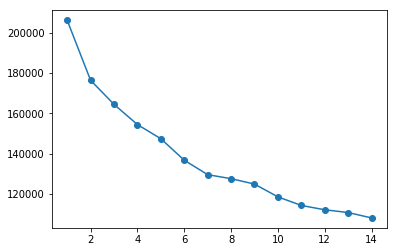

In [41]:
# Buscamos el número de clústeres óptimo por el método del codo
modelos = []
distancias = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(bf_clus_es)
    distancias.append(km.inertia_)
    modelos.append(km)
plt.plot(K, distancias, 'o-')
plt.show()

In [42]:
# No queda muy claro el codo en la gráfica, así que
# vemos qué valores toma la silueta para distintos k
from sklearn.metrics import silhouette_score

K = range(1,14)

for k in K:
    km = modelos[k]
    a = silhouette_score(bf_clus_es, km.predict(bf_clus_es))
    print "Silhouette con k = ", k, "es", a
 

Silhouette con k =  1 es 0.3331548912132804
Silhouette con k =  2 es 0.19372882800390168
Silhouette con k =  3 es 0.11983264219231086
Silhouette con k =  4 es 0.10708791947490477
Silhouette con k =  5 es 0.12222938226686625
Silhouette con k =  6 es 0.13220406336194146
Silhouette con k =  7 es 0.11049858513808254
Silhouette con k =  8 es 0.13420509488516522
Silhouette con k =  9 es 0.11297810680655296
Silhouette con k =  10 es 0.1242831695016489
Silhouette con k =  11 es 0.12289703743064731
Silhouette con k =  12 es 0.16271525811760978
Silhouette con k =  13 es 0.12660344021377137


La función Silhouette_score compara la distancia al clúster asignado con la distancia al clúster no asignado más cercano. El valor deseado sería 1 en el que los clústers estarían perfectamente delimitados. Los resultados obtenidos están cerca de 0, lo que significa que los clústeres están solapados. Por este motivo, no encontramos agrupaciones de registros significativas. 

In [34]:
#Aplicamos regresión para predecir el valor de purchase
#X se mantiene igual
#Y ahora será Purchase
Y = bf_data['Purchase']

#separamos los datos 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [35]:
clf = RandomForestRegressor(n_estimators=40)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)



In [36]:
from sklearn.metrics import r2_score
r2_score(Y_test, y_pred)


0.6881459843395261

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators = 100, max_depth = 5, min_samples_split = 2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

r2_score(Y_test, y_pred)

0.6800573938229765